**Titanic Project Proposal: Will a Passenger Survive?** 

Group 33 Members: Chloe Vaughan, Susan Zhang, James Drover, Olivia Klassen, and Adeeb Khan

**Introduction**

The RMS Titanic sank 5 days into her first trip in the Atlantic Ocean. Less than half of the passengers survived, and many factors contributed to their survival or demise. In this project, we will read, wrangle, and classify the titanic dataset in order to predict if a given passenger would have died in the accident. We will create visualizations to illustrate which variables may have played the biggest role in the survival of passengers and crew. 

[The Titanic dataset](https://www.kaggle.com/competitions/titanic/data?select=train.csv) was obtained by Kaggle. The original dataset included the following columns: survival (survived), ticket class (pclass), name of passenger (name), sex, age (in years), number of siblings/spouses aboard the Titanic (sibsp), number of parents/children aboard the Titanic (parch), ticket number (ticket), and passenger fare (fare). 

**Question**: Will a given passenger survive the incident, given the observations for each predictor variable? 
We’ll use the predictors outlined in Methods to predict a passenger's survival status (survived or passed), for new observations based on the K-nearest neighbours model.

**Methods**

The Titanic dataset will be cleaned and wrangled into a tidy format, in which the following variables will be omitted: passenger ID, name, embarked, ticket. These variables likely have no effect on classification as they are all titles with little bearing on real world events. Cabin number was omitted due to an overwhelming number of NA values. As well, all rows within this new set that have N/A as a value will be removed, and labels renamed to be human readable.

Survival, Class, Sex, Age, Number of Siblings on the Ship, Number of Parents/Children on the Ship, and fare will be used as variables for analysis. We will visualize the data using different types of visualizations to determine the impact of each on survival. Those with negligible impact on survival may be omitted from the prediction recipe, then the data will be trained to predict if a given passenger will survive.

**Expected Outcomes and Significance**

We anticipate sex and age to be the most important predictors of survival because women and children were presumably given priority in lifeboats at the time. Due to decreased physical fitness, those over the age of 50 are prone to more casualties. It is also believed that passengers who paid a larger fee will have a higher chance of surviving because wealthier customers were probably given priority while boarding lifeboats, as opposed to poor passengers, whose lives were given less consideration at the time.

The significance of our findings will provide quantitative support for the hierarchy in which passengers were prioritized for leaving the Titanic. This analysis allows better understanding of the political environment during which the Titanic sank, and how this impacted the lives of those onboard. It is important to present and analyze this data so that we can think about how we might prioritize lives if a similar event were to occur.  How was the lifeboat distribution prioritzied, and was it fair? Would we do things differently now, seeing as we have evolved towards equity as a society?  


**Preliminary Exploratory Data Analysis Below**

In [34]:
#necessary libraries to install
library(tidyverse)
library(tidymodels)

In [35]:
boat_data <- read_csv("data/train.csv")
boat_data

Rows: 891 Columns: 12
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): Name, Sex, Ticket, Cabin, Embarked
dbl (7): PassengerId, Survived, Pclass, Age, SibSp, Parch, Fare

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
<dbl>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<dbl>,<chr>,<chr>
1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NA,S
2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Thayer)",female,38,1,0,PC 17599,71.2833,C85,C
3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NA,S
4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S
5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NA,S
6,0,3,"Moran, Mr. James",male,NA,0,0,330877,8.4583,NA,Q
7,0,1,"McCarthy, Mr. Timothy J",male,54,0,0,17463,51.8625,E46,S
8,0,3,"Palsson, Master. Gosta Leonard",male,2,3,1,349909,21.0750,NA,S
9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27,0,2,347742,11.1333,NA,S


In [36]:
#getting rid of PassengerId,Name, Embarked,Ticket and Cabin:
boat_data_selected <- boat_data |>
    select(-PassengerId, -Name, -Embarked, -Ticket, -Cabin)
boat_data_selected

Survived,Pclass,Sex,Age,SibSp,Parch,Fare
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>
0,3,male,22,1,0,7.2500
1,1,female,38,1,0,71.2833
1,3,female,26,0,0,7.9250
1,1,female,35,1,0,53.1000
0,3,male,35,0,0,8.0500
0,3,male,NA,0,0,8.4583
0,1,male,54,0,0,51.8625
0,3,male,2,3,1,21.0750
1,3,female,27,0,2,11.1333


In [37]:
#renaming columns

colnames(boat_data_selected) = c("Survived", "Passenger_Class", "Sex", "Age", "Number0fSiblings", "NumberofParents_children", "Fare")

In [38]:
#adding a column for sex in binary(for it to work with the knn model)

boat_data_binary <- boat_data_selected |>
    mutate(sex_binary = ifelse(Sex == "male", 1, ifelse(Sex == "female", 0, NA)))
nrow(boat_data_binary)
boat_data_binary

[1] 891

Survived,Passenger_Class,Sex,Age,Number0fSiblings,NumberofParents_children,Fare,sex_binary
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,3,male,22,1,0,7.2500,1
1,1,female,38,1,0,71.2833,0
1,3,female,26,0,0,7.9250,0
1,1,female,35,1,0,53.1000,0
0,3,male,35,0,0,8.0500,1
0,3,male,NA,0,0,8.4583,1
0,1,male,54,0,0,51.8625,1
0,3,male,2,3,1,21.0750,1
1,3,female,27,0,2,11.1333,0


In [39]:
#removing the columns with NA values for age.
#we see we only loose about 20 percent of the original 891 row dataset

boat_data_NA <- boat_data_binary |>
    filter(!is.na(Age))
nrow(boat_data_NA)
boat_data_NA

[1] 714

Survived,Passenger_Class,Sex,Age,Number0fSiblings,NumberofParents_children,Fare,sex_binary
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0,3,male,22,1,0,7.2500,1
1,1,female,38,1,0,71.2833,0
1,3,female,26,0,0,7.9250,0
1,1,female,35,1,0,53.1000,0
0,3,male,35,0,0,8.0500,1
0,1,male,54,0,0,51.8625,1
0,3,male,2,3,1,21.0750,1
1,3,female,27,0,2,11.1333,0
1,2,female,14,1,0,30.0708,0


In [40]:
#splitting the wrangled data into test and training sets
#we chose a 70-30 percent split to ensure our model is accurate at the same time as making sure the testing is accurate.

boat_split <- initial_split(boat_data_NA, prop = 0.7, strata = Survived)
boat_train <- training(boat_split)
boat_test <- testing(boat_split)

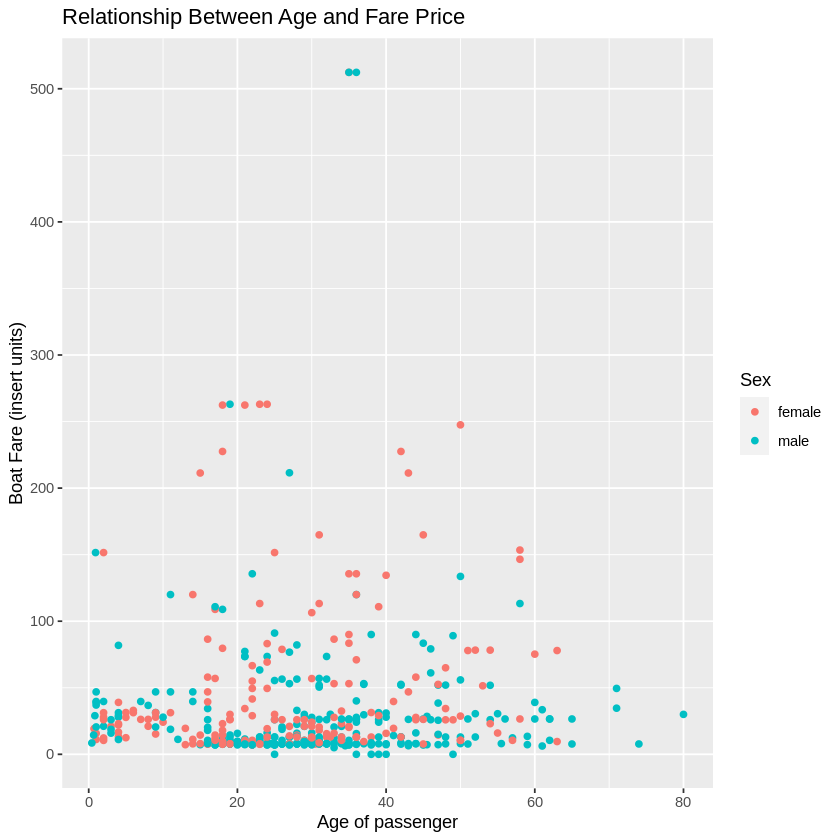

In [41]:
# visualisation (scatter plot) of the Fare vs age of passenger, colouring by sex.

fare_plot <- boat_train |> ggplot(aes(x = Age, y = Fare, colour = Sex)) + 
    geom_point() + 
    labs(x = "Age of passenger", y = "Boat Fare (insert units)", colour = "Sex") +
    ggtitle("Relationship Between Age and Fare Price")

fare_plot #Age appears to have no effect on fare price, with the exception of a few outliers

Survived,Passenger_Class,Sex,Age,Number0fSiblings,NumberofParents_children,Fare,sex_binary,Survived_char
<dbl>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>
0,3,male,22,1,0,7.2500,1,Did not survive
0,3,male,35,0,0,8.0500,1,Did not survive
0,1,male,54,0,0,51.8625,1,Did not survive
0,3,male,2,3,1,21.0750,1,Did not survive
0,3,male,20,0,0,8.0500,1,Did not survive
0,3,male,39,1,5,31.2750,1,Did not survive
0,3,female,14,0,0,7.8542,0,Did not survive
0,3,female,31,1,0,18.0000,0,Did not survive
0,2,male,35,0,0,26.0000,1,Did not survive


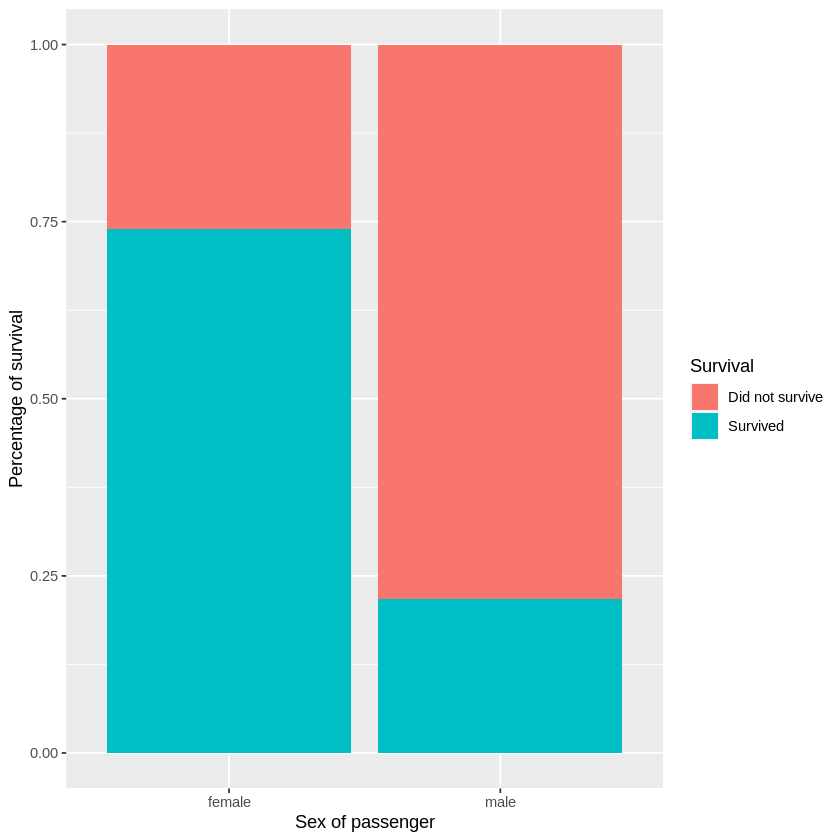

In [42]:
#bar graph to display how many people survived vs how many did not.(percentage of survival)

temp_data_graph <- boat_train |>
    mutate(Survived_char = ifelse(Survived == 1, "Survived", ifelse(Survived == 0, "Did not survive", NA)))

temp_data_graph

survival_bar_plot <- ggplot(temp_data_graph, aes(x = Sex, fill = as_factor(Survived_char))) +
    geom_bar(position = "fill") +
    labs(x = "Sex of passenger", y = "Percentage of survival", fill = "Survival")

survival_bar_plot

In [45]:
#summary table for how many men and women are there in the training data.

summary_table_sex <- boat_train |>
    group_by(Sex) |>
    summarize(Number_of_passengers = n())

summary_table_sex

#this table emphasizes the importance of looking at the proportion of women that survived versus women that passed
#more men boarded the ship, thus more men having passed than women is not surprising, proportion of survival within each sex is important

Sex,Number_of_passengers
<chr>,<int>
female,181
male,318


In [44]:
#Adding summary table for age (years) for training data

summary_table_age <- boat_train |>
    summarize(mean_age = mean(Age))

summary_table_age

#adding a summary table for the number of passengers in each class for training data:

summary_table_class <- boat_train |>
    group_by(Passenger_Class) |>
    summarize(Number_of_passengers = n())

summary_table_class

#Adding summary table for number of children for training data

summary_table_children <- boat_train |>
    summarize(mean_children = mean(NumberofParents_children))

summary_table_children

mean_age
<dbl>
28.68605


Passenger_Class,Number_of_passengers
<dbl>,<int>
1,127
2,114
3,258


mean_children
<dbl>
0.4569138
